In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import time
from tqdm import tqdm
from itertools import combinations

from GA_params_class.GeneticAlgorithm import GeneticAlgorithm
from function_module import *

In [2]:
cnn_model_path = '../../Models/CNN_6_1_2.keras'
masked_sequence = 'AATACTAGAGGTCTTCCGACNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGTGTGGGCGGGAAGACAACTAGGGG'
target_expressions = [0, 0.5, 1]
precision = None
verbose = 0
lineages = 10

In [11]:
# Calculation functions

def calculate_hamm_distance(str1, str2):
    return sum([1 for s, t in zip(str1, str2) if s != t])

def calculate_average_hamm_distance(pop1, pop2):
    '''Calculate the average hamming distance between all pairs of sequences in two populations'''
    total_distance = 0
    pair_count = 0
    
    for i in range(len(pop1)):
        for j in range(len(pop2)):
            total_distance += calculate_hamm_distance(pop1[i], pop2[j])
            pair_count += 1
    
    return total_distance / pair_count if pair_count > 0 else 0

def calculate_average_fitness(data):
    average_fitness = [[[] for island in lineage] for lineage in data]
    
    for lineage_idx, lineage in enumerate(data):
        for island_idx, island in enumerate(lineage):
            for genergation in island:
                average_fitness[lineage_idx][island_idx].append(np.mean(genergation))
    
    return average_fitness

def calculate_inter_lineage_hamm(infill_history):
    lineage_averages = {}
    # Calculate average hamming distance between all pairs of sequences in each generation
    for lineage_idx, lineage in enumerate(infill_history):
        lineage_averages[lineage_idx] = {}
        for island_idx, island in enumerate(lineage):
            generation_distances = []
            for generation in island:
                num_sequences = len(generation)
                
                if num_sequences < 2:
                    generation_distances.append(0)
                    continue
                
                total_distance = 0
                pair_count = 0
                
                for i in range(num_sequences):
                    for j in range(i + 1, num_sequences):
                        total_distance += calculate_hamm_distance(generation[i], generation[j])
                        pair_count += 1
                
                generation_distances.append(total_distance / pair_count if pair_count > 0 else 0)
            lineage_averages[lineage_idx][island_idx] = generation_distances

    return lineage_averages

def calculate_intra_lineage_hamm(infill_history):
    # Group all individuals by generation, removing islands
    data = [[[] for generation in range(len(infill_history[0][0]))] for lineage in range(len(infill_history))]
    for lineage_idx, lineage in enumerate(infill_history):
        for island in lineage:
            for generation_idx, generation in enumerate(island):
                data[lineage_idx][generation_idx].extend(generation)

    # Calculate average hamming distance between each individual of DIFFERENT lineages, for each generation
    distances = [0 for generation in data[0]]
    for lineage1, lineage2 in combinations(data, 2):
        for generation_idx, generation in enumerate(lineage1):
            distances[generation_idx] += calculate_average_hamm_distance(generation, lineage2[generation_idx])
    return distances

In [8]:
# Graphing functions

def plot_fitnesses(data):
    plt.figure(figsize=(8, 6))
    for lineage_idx, lineage in enumerate(data):
        for island_idx, island in enumerate(lineage):
            generations = range(1, len(island) + 1)
            plt.plot(generations, island, label=f"Lineage {lineage_idx}, Island {island_idx}")
        
    plt.xlabel("Generations")
    plt.ylabel("Fitness")
    plt.legend()
    plt.show()

def plot_inter_hamm(data):
    plt.figure(figsize=(10, 6))
    for lineage_idx, islands in data.items():
        for island_idx, distances in islands.items():
            generations = range(len(distances))
            plt.plot(generations, distances, label=f'Lineage{lineage_idx}, Island {island_idx}')
        
    plt.xlabel('Generation')
    plt.ylabel('Average Hamming Distance')
    plt.legend()
    plt.show()

def plot_intra_hamm(data):
    plt.figure(figsize=(10, 6))
    generations = range(len(data))
    plt.plot(generations, data)
    
    plt.xlabel('Generation')
    plt.ylabel('Average Hamming Distance')
    plt.show()

def plot_intra_hamm_comparison(datas, lineage_divergence_alpha):
    plt.figure(figsize=(10, 6))
    for idx, data in enumerate(datas):
        generations = range(len(data))
        plt.plot(generations, data, label=f'Alpha = {lineage_divergence_alpha[idx]}')
    
    plt.xlabel('Generation')
    plt.ylabel('Average Hamming Distance')
    plt.legend()
    plt.show()

Instructions for updating:
Use tf.identity with explicit device placement instead.


c:\Users\rsore\anaconda3\envs\TX_prediction\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 34 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


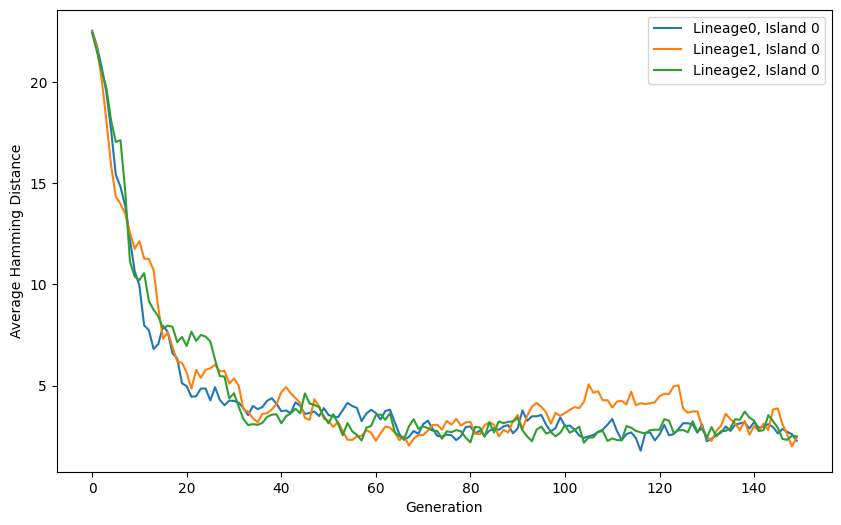

In [5]:
ga1 = GeneticAlgorithm(
    cnn_model_path=cnn_model_path,
    masked_sequence=masked_sequence,
    target_expression=target_expressions[0],
    precision=precision,
    verbose=verbose,
    lineage_divergence_alpha=0,
    seed=0,
)
best_sequences1, best_predictions1 = ga1.run(3)
infill_history1 = ga1.get_infill_history()

inter_lineage_hamm1 = calculate_inter_lineage_hamm(infill_history1)
plot_inter_hamm(inter_lineage_hamm1)

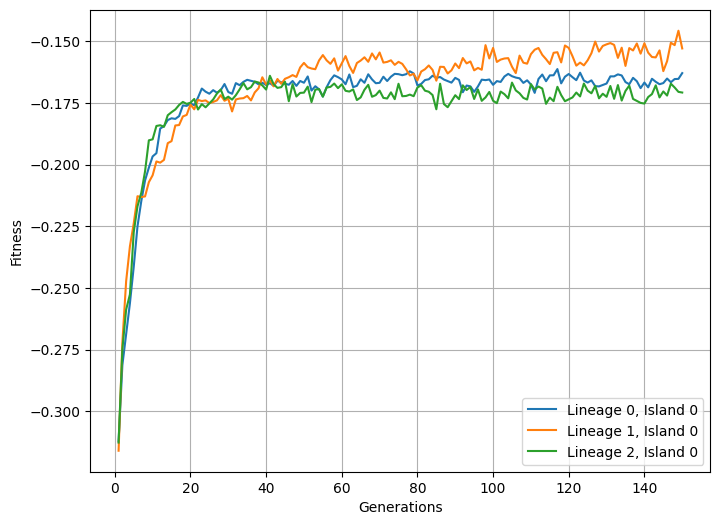

In [6]:
fitness_history1 = ga1.get_fitness_history()
average_fitness1 = calculate_average_fitness(fitness_history1)
plot_fitnesses(average_fitness1)

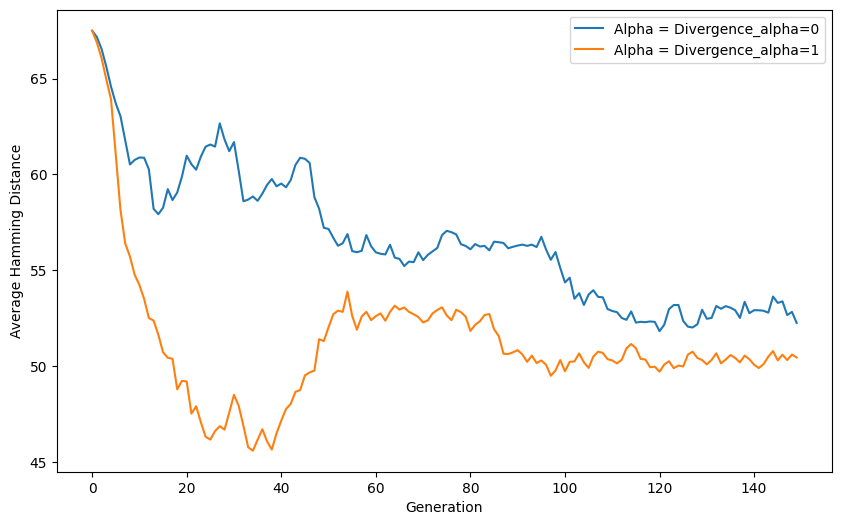

In [12]:
ga2 = GeneticAlgorithm(
    cnn_model_path=cnn_model_path,
    masked_sequence=masked_sequence,
    target_expression=target_expressions[0],
    precision=precision,
    verbose=verbose,
    lineage_divergence_alpha=1,
    seed=0,
)
best_sequences2, best_predictions2 = ga2.run(3)
infill_history2 = ga2.get_infill_history()

# Calculate average intra-lineage hamming distance for each GA
intra_lineage_hamm1 = calculate_intra_lineage_hamm(infill_history1)
intra_lineage_hamm2 = calculate_intra_lineage_hamm(infill_history2)

plot_intra_hamm_comparison([intra_lineage_hamm1, intra_lineage_hamm2], ['Divergence_alpha=0', 'Divergence_alpha=1'])